In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Load the dataset

In [4]:
data = fetch_openml('diabetes', version=1, as_frame=True)
df = data.frame
df

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,tested_negative
764,2,122,70,27,0,36.8,0.340,27,tested_negative
765,5,121,72,23,112,26.2,0.245,30,tested_negative
766,1,126,60,0,0,30.1,0.349,47,tested_positive


In [6]:
df.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [7]:
df.dtypes

,0
preg,int64
plas,int64
pres,int64
skin,int64
insu,int64
mass,float64
pedi,float64
age,int64
class,category


## Seperate features and target

In [9]:
X = df.drop(columns=["class"])
y = (df["class"] == "tested_positive").astype(int)

scalar = MinMaxScaler()
X_scaled = scalar.fit_transform(X)

print(X_scaled)
print(y)

[[0.35294118 0.74371859 0.59016393 ... 0.50074516 0.23441503 0.48333333]
 [0.05882353 0.42713568 0.54098361 ... 0.39642325 0.11656704 0.16666667]
 [0.47058824 0.91959799 0.52459016 ... 0.34724292 0.25362938 0.18333333]
 ...
 [0.29411765 0.6080402  0.59016393 ... 0.390462   0.07130658 0.15      ]
 [0.05882353 0.63316583 0.49180328 ... 0.4485842  0.11571307 0.43333333]
 [0.05882353 0.46733668 0.57377049 ... 0.45305514 0.10119556 0.03333333]]
0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: class, Length: 768, dtype: int64


In [15]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [16]:
# Use only non-diabetic data for training the autoencoder
X_train_normal = X_train[y_train == 0]

In [17]:
# Convert data to pytorch tensors
X_train_normal = torch.tensor(X_train_normal, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.int)


## Define the Autoencoder

In [19]:
class Autoencoder(nn.Module):
  def __init__(self, input_dim, encoding_dim):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 16),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, encoding_dim),
        nn.ReLU()
    )

    self.decoder = nn.Sequential(
        nn.Linear(encoding_dim, 8),
        nn.ReLU(),
        nn.Linear(8, 16),
        nn.ReLU(),
        nn.Linear(16, input_dim),
        nn.Sigmoid()
    )

  def forward(self, x):
    z = self.encoder(x)
    x_hat = self.decoder(z)
    return x_hat


## Train the model

In [27]:
from torch.utils.data import DataLoader, TensorDataset

input_dim = X_train_normal.shape[1]
encoding_dim = 4
batch_size = 32
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

dataset = TensorDataset(X_train_normal)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

epochs = 120
losses = []

model.train()

for epoch in range(epochs):
  epoch_loss = 0

  for batch in dataloader:
    batch = batch[0]
    optimizer.zero_grad()
    outputs = model(batch)
    loss = criterion(outputs, batch)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  losses.append(epoch_loss / len(dataloader.dataset))
  print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataloader.dataset):.4f}")

Epoch 1/120, Loss: 0.0025
Epoch 2/120, Loss: 0.0024
Epoch 3/120, Loss: 0.0022
Epoch 4/120, Loss: 0.0021
Epoch 5/120, Loss: 0.0019
Epoch 6/120, Loss: 0.0018
Epoch 7/120, Loss: 0.0015
Epoch 8/120, Loss: 0.0013
Epoch 9/120, Loss: 0.0011
Epoch 10/120, Loss: 0.0009
Epoch 11/120, Loss: 0.0008
Epoch 12/120, Loss: 0.0007
Epoch 13/120, Loss: 0.0007
Epoch 14/120, Loss: 0.0007
Epoch 15/120, Loss: 0.0007
Epoch 16/120, Loss: 0.0007
Epoch 17/120, Loss: 0.0007
Epoch 18/120, Loss: 0.0007
Epoch 19/120, Loss: 0.0007
Epoch 20/120, Loss: 0.0006
Epoch 21/120, Loss: 0.0006
Epoch 22/120, Loss: 0.0006
Epoch 23/120, Loss: 0.0006
Epoch 24/120, Loss: 0.0006
Epoch 25/120, Loss: 0.0006
Epoch 26/120, Loss: 0.0006
Epoch 27/120, Loss: 0.0006
Epoch 28/120, Loss: 0.0006
Epoch 29/120, Loss: 0.0006
Epoch 30/120, Loss: 0.0006
Epoch 31/120, Loss: 0.0005
Epoch 32/120, Loss: 0.0005
Epoch 33/120, Loss: 0.0005
Epoch 34/120, Loss: 0.0005
Epoch 35/120, Loss: 0.0005
Epoch 36/120, Loss: 0.0005
Epoch 37/120, Loss: 0.0005
Epoch 38/1

## Plot the training loss

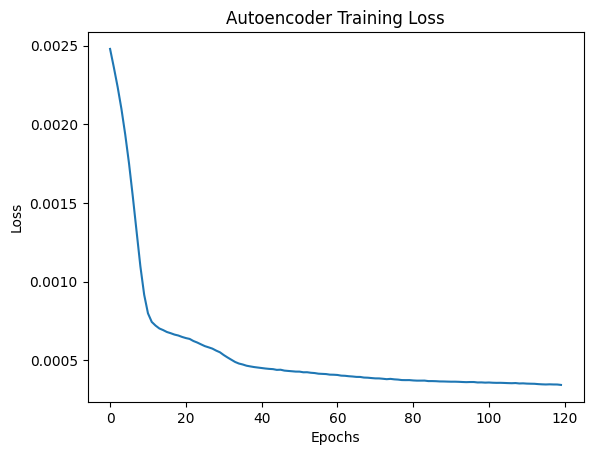

In [28]:
# Plot training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss')
plt.show()

## Evaluate the encoder on the test data

In [29]:
import torch.nn.functional as F

model.eval()
with torch.no_grad():
  X_test_reconstructed = model(X_test)
  reconstruction_error = F.mse_loss(X_test, X_test_reconstructed, reduction='none').mean(dim=1)

print(reconstruction_error)

tensor([0.0037, 0.0072, 0.0026, 0.0141, 0.0009, 0.0075, 0.0027, 0.0620, 0.0075,
        0.0099, 0.0108, 0.0183, 0.0178, 0.0058, 0.0031, 0.0061, 0.0065, 0.0049,
        0.0641, 0.0108, 0.0047, 0.0044, 0.0285, 0.0018, 0.0093, 0.0197, 0.0082,
        0.0036, 0.0150, 0.0036, 0.0356, 0.0182, 0.0303, 0.0566, 0.0250, 0.0147,
        0.1060, 0.0157, 0.0032, 0.0427, 0.0044, 0.0337, 0.0082, 0.0228, 0.0109,
        0.0145, 0.0201, 0.0059, 0.0099, 0.0552, 0.0058, 0.0084, 0.0228, 0.0043,
        0.0105, 0.0047, 0.0112, 0.0437, 0.0057, 0.0096, 0.0082, 0.0036, 0.0239,
        0.0220, 0.0103, 0.0288, 0.0026, 0.0182, 0.0077, 0.0488, 0.0130, 0.0056,
        0.0093, 0.0083, 0.0075, 0.0251, 0.0156, 0.0065, 0.0052, 0.0055, 0.0091,
        0.0036, 0.0054, 0.0232, 0.0055, 0.0220, 0.0257, 0.0049, 0.0043, 0.0027,
        0.0011, 0.0096, 0.0417, 0.0577, 0.0062, 0.0161, 0.0129, 0.0025, 0.0465,
        0.0143, 0.0289, 0.0122, 0.0242, 0.0115, 0.0123, 0.0113, 0.0074, 0.0207,
        0.0148, 0.0082, 0.0036, 0.0085, 

## Anomaly Detection

In [30]:
reconstruction_error = reconstruction_error.numpy()

# 95th percentile of normal reconstruction errors
threshold = np.percentile(reconstruction_error[y_test.numpy() == 0], 95)
print(threshold)

0.04270969703793526


In [32]:
# predict anomalies
y_pred = (reconstruction_error > threshold).astype(int)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

## Evaluation

In [33]:
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix: 
 [[143   8]
 [ 71   9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.95      0.78       151
           1       0.53      0.11      0.19        80

    accuracy                           0.66       231
   macro avg       0.60      0.53      0.48       231
weighted avg       0.62      0.66      0.58       231

